<a href="https://www.kaggle.com/code/syerramilli/fraud-detection-via-autoencoders?scriptVersionId=145488815" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

The main task in this dataset is to predict which of the transactions are fraudulent, based on several numerical measures. A major challenge is the large class imbalance in the data - only 0.17% of the transactions are fraudulent. It will be difficult to train classification models with good discriminative power. 

In this notebook, we take an alternative approach by employing an autoencoder-based anomaly detection method to classify transactions. The underlying assumption is that if the features carry some relevance for predicting fraud, then fraudulent transactions are likely to be outliers within the feature space when compared to non-fraudulent transactions. To implement this approach, we train the autoencoder only on the non-fraudulent transactions. Subsequently, the reconstruction error derived from this autoencoder serves as the foundation for constructing a decision function to classify transactions as fraudulent or not. 

Given the dataset's substantial class imbalance, we will evaluate model performance using the area under the precision-recall curve, which is a suitable metric for assessing model quality in such imbalanced scenarios.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.manifold import TSNE

import joblib

from typing import Dict, Optional, List, Tuple
from numbers import Number

plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi':150})

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading the data

**Note**: We drop the `Time` feature since we don't know how to interpret it yet.

In [2]:
raw_df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv').drop('Time', axis=1)
raw_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(f'Number of observations: {raw_df.shape[0]}')

Number of observations: 284807


In [4]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print(f'Number of positive observations: {pos} ({100*pos / total:.2f}% of total)')

Number of positive observations: 492 (0.17% of total)


## Generating training, validation and test splits

In [5]:
train_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=1, stratify=raw_df['Class'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2, stratify=train_df['Class'])

In [6]:
y_train = train_df.pop('Class').values
y_val = val_df.pop('Class').values
y_test = test_df.pop('Class').values

In [7]:
for tag, labels in zip(['training', 'validation', 'test'], [y_train, y_val, y_test]):
    print(f'Percentage of positive class observations in {tag} set: {labels.mean()*100:.3f}')

Percentage of positive class observations in training set: 0.173
Percentage of positive class observations in validation set: 0.173
Percentage of positive class observations in test set: 0.172


## Basic EDA

In [8]:
def filter_greater_than(series:pd.Series,threshold:Number) -> pd.Series:
    '''
    Returns series elements greater than threshold. This funtion can be
    used with the .pipe methods
    '''
    return series[series>threshold]


def get_missing_percentage(df:pd.DataFrame) -> pd.Series:
    '''
    Returns the percentages of missing values for columns 
    in `df`that have atleast one missing entry
    '''
    
    return (
        (df.isnull().sum()/df.shape[0]*100)
        .sort_values(ascending=False)
        .pipe(filter_greater_than,threshold=0)
        .round(3)
    )


for tag, df in zip(['training', 'validation', 'test'], [train_df, val_df, test_df]):
    print(f'Percentage of missing entries per column in {tag} set (if any):')
    print(get_missing_percentage(df))
    print()

Percentage of missing entries per column in training set (if any):
Series([], dtype: float64)

Percentage of missing entries per column in validation set (if any):
Series([], dtype: float64)

Percentage of missing entries per column in test set (if any):
Series([], dtype: float64)



In [9]:
skew_columns = train_df.skew()
pos_skew = {}
neg_skew = {}

for column, skew in skew_columns.items():
    if skew > 1:
        pos_skew[column] = skew
    elif skew < -1:
        neg_skew[column] = skew
        
print(f'Number of columns that are positively skewed: {len(pos_skew)}')
print(f'Number of columns that are negatively skewed: {len(neg_skew)}')

Number of columns that are positively skewed: 6
Number of columns that are negatively skewed: 11


For simplicity, we preprocess all the columns through the `QuantileTransformer` in scikit-learn, so that the transformed features are (roughly) normally distributed across the training set.

In [10]:
qt_transform = QuantileTransformer(output_distribution='normal')
X_train = qt_transform.fit_transform(train_df)
X_val = qt_transform.transform(val_df)
X_test = qt_transform.transform(test_df)

## Autoencoder architecture

The autoencoder architecture consists mainly of two components: the encoder and the decoder. The encoder is responsible for producing a compressed latent representation of the input data, whereas the decoder's role is to reconstruct the original inputs from this latent representation. Due to the compression process, some information loss is inevitable. Nevertheless, the autoencoder is designed to capture and preserve the most essential characteristics within the feature space, effectively mitigating this loss of information.

In our implementation, as showcased in the cell below, we leverage the functional API within Keras to separately construct the encoder and decoder components. Note that these components can also be created within a single Keras sequential class. The constructor functions optionally accept architectural hyperparameters as well as the learning rate specification (the `params` argument in each function). The architecture we will use in this notebook is as follows:

1. Encoder: 
    - The encoder consistss of 3 hidden layers followed by the latent dense layer. 
    - The default dimension of the latent space (`latent_dim`) is 16. This has to be less than the number of features for the autoencoder to work. 
    - Each hidden layers consists of a dense layer followed by batch normalization, leaky ReLU activation layer with slope 0.2, and dropout
    
2. Decoder:
    - The decoder consists of 3 hidden layers followed by the reconstruction dense layer.
    - Each hidden layer in the decoder consists consists of a dense layer followed by batch normalization, ReLU activation, and dropout.
    
    
**Note**: 

1. Why use Leaky ReLU as the activation function in the encoder instead of ReLU?

    ReLU activation outputs zero for any negative input, which can result in a loss of information. The Leaky ReLU function is similar to the ReLU function, except that has small slope for negative numbers. Therefore, the leaky ReLU allows small negative values to the output, which can help preserve information in the data.

2. The slope coefficient for negative values in Leaky ReLU is fixed before training, i.e. it is not learnt during training. We use a slope of 0.2 here



In [11]:
def encoder(inputs, params={}):
    x = inputs
    for i in range(params.get('n_hidden_encoder',3)):
        x = keras.layers.Dense(params.get(f'hsize_encoder{i}', 128//2**i), activation=None, name=f'encoder_dense_{i}')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU(0.2)(x)
        x = keras.layers.Dropout(params.get(f'dropout_encoder{i}', 0.05))(x)
        
    # final bottleneck layer
    x = keras.layers.Dense(params.get(f'latent_dim', 16), activation=None, name='bottleneck')(x)
    
    return x

def decoder(inputs, input_dim, params={}):
    x = inputs
    n_hidden_decoder = params.get('n_hidden_decoder', 3)
    for i in range(n_hidden_decoder):
        x = keras.layers.Dense(params.get(f'hsize_decoder{i}', 128//2**(n_hidden_decoder-i-1)), activation=None, name=f'decoder_dense_{i}')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        x = keras.layers.Dropout(params.get(f'dropout_decoder{i}', 0.05))(x)
    
    # output
    x = keras.layers.Dense(input_dim, activation=None)(x)
    return x


def dense_autoencoder(input_dim, params={}):
    inputs = keras.Input(shape=(input_dim,))
    encoder_output = encoder(inputs, params)
    decoder_output = decoder(encoder_output, input_dim, params)
    
    model = keras.Model(inputs=inputs, outputs=decoder_output)
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=params.get('learning_rate', 0.01),
        ),
        loss='mean_squared_error'
    )

    return model

In [12]:
keras.backend.clear_session()
ae_model = dense_autoencoder(X_train.shape[1])
ae_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 encoder_dense_0 (Dense)     (None, 128)               3840      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 encoder_dense_1 (Dense)     (None, 64)                8256      
                                                             

## Training the autoencoder

As previously mentioned in the introduction, our approach involves training the autoencoder exclusively on the non-fraudulent transactions. The primary goal is to minimize the reconstruction error generated by the network. This strategy is grounded in the assumption that non-fraudulent transactions provide a reliable representation of typical, legitimate data patterns.

To optimize the training process and ensure the best model performance, we employ two key techniques:

1. Early Stopping: Early stopping is a mechanism used during training to prevent overfitting. By monitoring the reconstruction error on the validation set (comprising non-fraudulent transactions), we can halt training when the error starts to increase or stagnate. This ensures that we stop training before the model becomes overly specialized to the training data, resulting in better generalization to unseen data.
2. Learning Rate Scheduler: We use a learning rate scheduler that adjusts the learning rate during training based on the reconstruction error of the non-fraudulent transactions in the validation set. When the error plateaus or increases, the learning rate is halved.

By incorporating these strategies, we aim to train an autoencoder that effectively captures the underlying patterns of legitimate transactions. This approach is crucial in building a reliable anomaly detection system, where the autoencoder's reconstruction error serves as a key metric for identifying suspicious or fraudulent activities.

In [13]:
EPOCHS = 100
BATCH_SIZE = 256
    
    
# callbacks - reduce lr on plateau and early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=True,
    patience=15,
    restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    verbose=True,
    patience=5,
    factor= 0.1,
    min_lr = 1e-5
)

history = ae_model.fit(
    X_train[y_train==0,:],
    X_train[y_train==0,:],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks = [early_stopping, reduce_lr], 
    validation_data=(X_val[y_val==0], X_val[y_val==0])
)

Epoch 1/100
711/711 [==============================] - 9s 8ms/step - loss: 0.3494 - val_loss: 0.1630 - lr: 0.0100
Epoch 2/100
711/711 [==============================] - 5s 7ms/step - loss: 0.2329 - val_loss: 0.1216 - lr: 0.0100
Epoch 3/100
711/711 [==============================] - 5s 7ms/step - loss: 0.2116 - val_loss: 0.1060 - lr: 0.0100
Epoch 4/100
711/711 [==============================] - 5s 6ms/step - loss: 0.2014 - val_loss: 0.0948 - lr: 0.0100
Epoch 5/100
711/711 [==============================] - 5s 7ms/step - loss: 0.1949 - val_loss: 0.0881 - lr: 0.0100
Epoch 6/100
711/711 [==============================] - 5s 7ms/step - loss: 0.1892 - val_loss: 0.0874 - lr: 0.0100
Epoch 7/100
711/711 [==============================] - 5s 6ms/step - loss: 0.1842 - val_loss: 0.0795 - lr: 0.0100
Epoch 8/100
711/711 [==============================] - 5s 7ms/step - loss: 0.1807 - val_loss: 0.0787 - lr: 0.0100
Epoch 9/100
711/711 [==============================] - 5s 6ms/step - loss: 0.1768 - val_

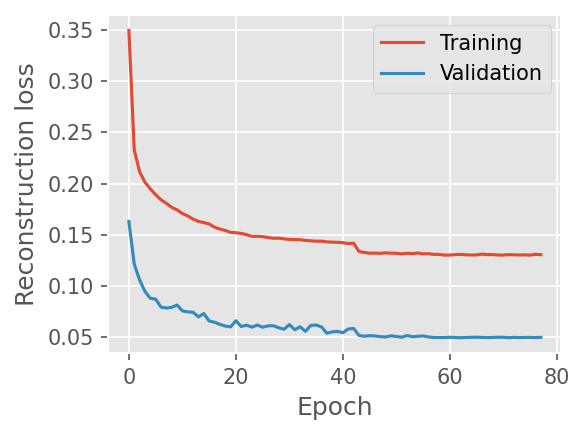

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(4,3))
metric = 'loss'
_ = axs.plot(history.epoch, history.history[f'{metric}'], label='Training')
_ = axs.plot(history.epoch, history.history[f'val_{metric}'], label='Validation')                 
_ = axs.legend()
_ = axs.set_xlabel('Epoch')
_ = axs.set_ylabel('Reconstruction loss')
fig.tight_layout()

In [15]:
# save_model
ae_model.save('ae_model.h5')

## Reconstruction loss across classes

For each observation, we define the reconstruction loss as the sum of the squared differences between its features and uts corresponding reconstructed output from the autoencoder.

In [16]:
def get_reconst_loss(X):
    X_reconst = ae_model.predict(X, batch_size=256)
    return (
        ((X-X_reconst)**2).sum(axis=1)
    )

In the cell below, we have generated a histogram plotting the log-transformed values of (1 + reconstruction loss) for the two distinct classes. The y-axis represents the density within each class. As anticipated, the fraudulent transactions tend to exhibit significantly higher reconstruction losses compared to the non-fraudulent ones. This observation underscores the utility of the reconstruction loss as a reliable criterion for classifying transactions as either fraudulent or legitimate.

713/713 [==============================] - 1s 2ms/step


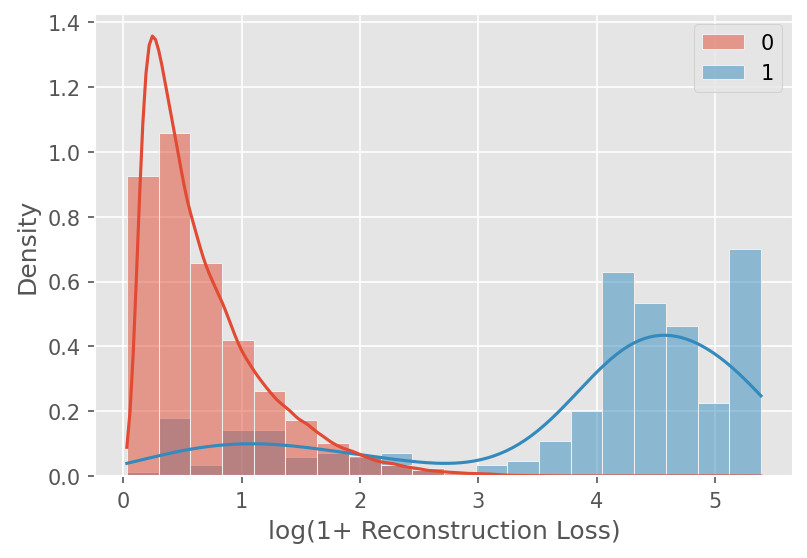

In [17]:
reconst_train = get_reconst_loss(X_train)

fig, ax = plt.subplots(1,1, figsize=(6,4))
_ = sns.histplot(
    x=np.log1p(reconst_train),hue=y_train, bins=20, 
    stat='density',kde=True, common_norm=False,
    alpha = 0.5, ax=ax
)
_ = ax.set_xlabel('log(1+ Reconstruction Loss)')

## Evaluating the performance of the models

In [18]:
reconst_val = get_reconst_loss(X_val)
reconst_test = get_reconst_loss(X_test)

223/223 [==============================] - 0s 2ms/step


### Area under the precision recall curve

We can use the reconstruction error to get the precision and recall at various thresholds. The function `pr_auc_score` computes the area under the precision recall curve.

In [19]:
def pr_auc_score(labels, predictions):
    # compute precision recall at several thresholds
    precision, recall, _ = precision_recall_curve(labels, predictions)
    
    return auc(recall, precision)

In [20]:
print(f'Area under PR curve for training set: {pr_auc_score(y_train, np.log1p(reconst_train)):.3f}')
print(f'Area under PR curve for validation set: {pr_auc_score(y_val, np.log1p(reconst_val)):.3f}')
print(f'Area under PR curve for test set: {pr_auc_score(y_test, np.log1p(reconst_test)):.3f}')

Area under PR curve for training set: 0.672
Area under PR curve for validation set: 0.675
Area under PR curve for test set: 0.790


## Precision recall curves

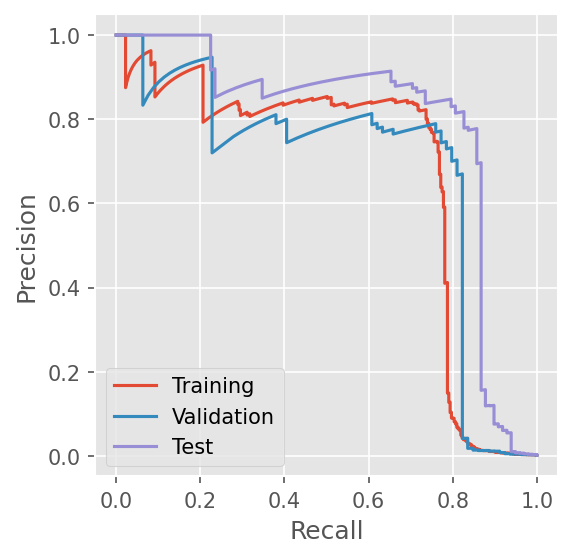

In [21]:
def plot_pr_curve(name, labels, predictions, ax, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    _ = ax.plot(recall, precision, label=name, **kwargs)
    _ = ax.set_ylabel('Precision')
    _ = ax.set_xlabel('Recall')
    _ = ax.grid(True)
    _ = ax.set_aspect('equal')
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4))


plot_pr_curve("Training", y_train, np.log1p(reconst_train), ax)
plot_pr_curve("Validation", y_val, np.log1p(reconst_val), ax)
plot_pr_curve("Test", y_test, np.log1p(reconst_test), ax)
_ = ax.legend(loc='lower left')

### Confusion matrix

Finally, we evaulate the confusion matrix on the test set, using various thresholds on the log(1+reconstruction loss) to generate the classes. The threshold should be chosen carefully depending on the business needs. For example, not identifying a fradulent transacation is typically considered more costly than raising a false alarm - the loss can also include other fraudulent transactions carried out on the compromised card.

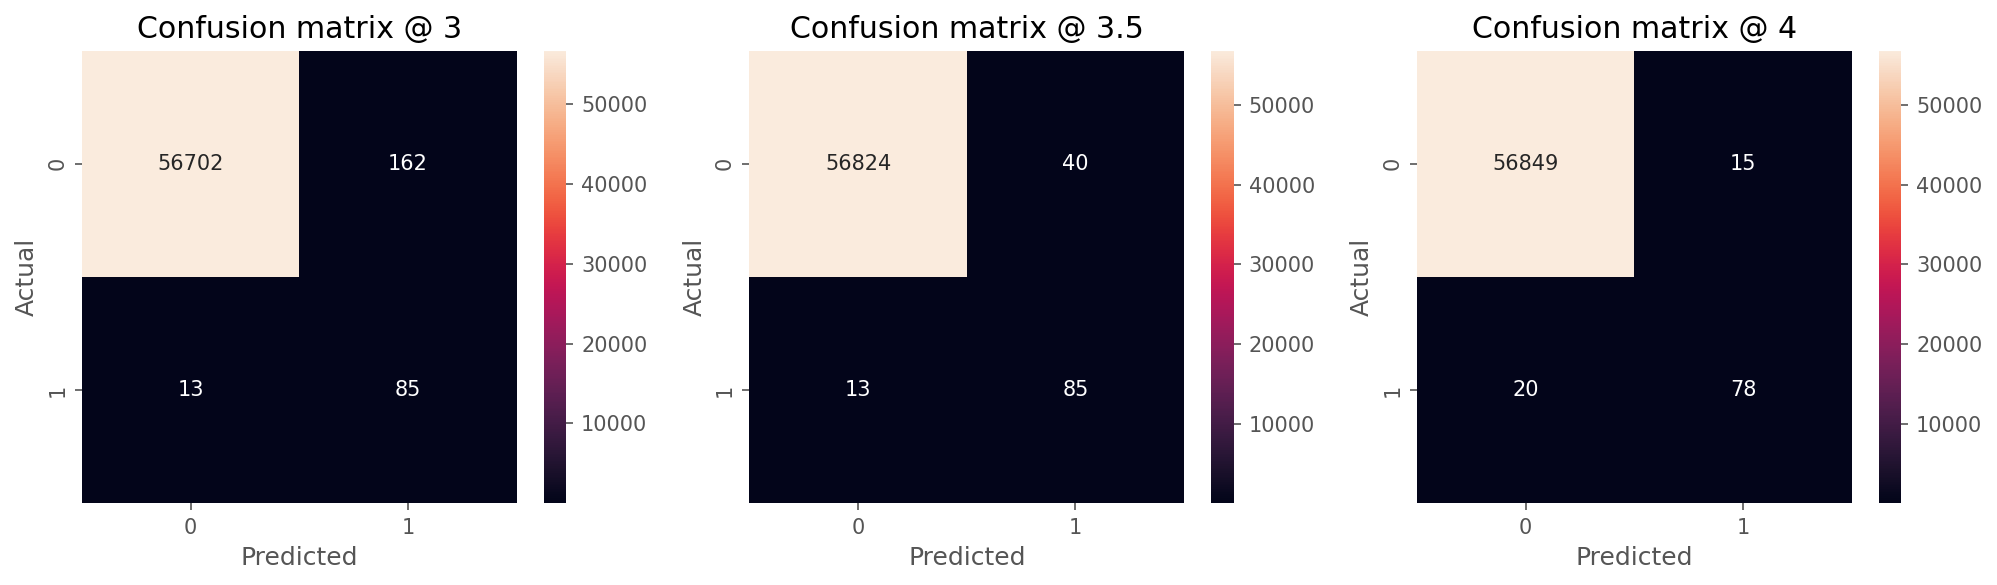

In [22]:
thresholds = [3, 3.5, 4]

fig, axs = plt.subplots(1, len(thresholds), figsize=(4.5*len(thresholds), 4))
for i, threshold in enumerate(thresholds):
    _ = sns.heatmap(confusion_matrix(y_test, np.log1p(reconst_test) > threshold), annot=True, ax=axs[i], fmt='g')
    _ = axs[i].set_ylabel('Actual')
    _ = axs[i].set_xlabel('Predicted')
    _ = axs[i].set_title(f'Confusion matrix @ {threshold}')
    
fig.tight_layout()

## Further directions

There are several directions to improve upon this work.

1. Feature selection: The current reconstruction loss function treats all features as equally important. However, it's highly probable that not all features hold the same predictive power. In fact, some features may not even be relevant for our task. Therefore, considering feature selection strategies becomes essential to align the reconstruction task more effectively with the classification task.
2. Calibration: In our approach, we didn't calculate class probabilities; instead, we relied on thresholds for the reconstruction loss. Enhancements in performance could potentially be achieved through calibration techniques, such as Platt's scaling or isotonic regression. These methods can fine-tune the decision boundaries and improve the model's ability to distinguish between fraudulent and non-fraudulent transactions.
3. Hyperparameter Tuning: Tuning the autoencoder hyperparameters can potentially improve performance.  It is crucial to emphasize that while tuning, our primary objective should be improving classification, rather than focusing solely on reconstruction quality. 